# Best Model Evaluation
**Use conda_tensorflow2_python 3 kernel!**

In [83]:
!pip install wandb scikit-plot -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [84]:
import json
import yaml
import wandb
import boto3
import base64
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from botocore.exceptions import ClientError
from containers.training_beta.Model import Model 
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
from containers.training_beta.DatasetGenerator import DatasetGenerator 

In [85]:
region = 'us-east-2'
metric = 'val_classification_accuracy'
sweep_id = 'rosenblatt/satellite-model-and-orientation/dqcsh4ar'

In [86]:
# TODO: add to a helpers class or something
def get_secret(secret_name, region_name):
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    
    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
    
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
        return json.loads(secret)
    else:
        decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
        return decoded_binary_secret

In [87]:
assert wandb.login(key=get_secret("wandb_api_key", region)["wandb_api_key"])
!rm -r wandb

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


In [88]:
import numpy as np
np.array([[1,2,3]]*3).flatten()

array([1, 2, 3, 1, 2, 3, 1, 2, 3])

## Download Weights of the Best Model

In [89]:
home = !pwd
home = home[0]
best_path = home + '/best'
! [ ! -d $best_path ] && mkdir best

In [90]:
api = wandb.Api()
sweep = api.sweep(sweep_id)
!rm -r wandb

In [91]:
runs = sorted(sweep.runs, key=lambda run: run.summary.get("best_val_classification_accuracy", 0), reverse=True)
val_cls_acc = runs[0].summary.get("best_val_classification_accuracy", 0)
print(f"Best run {runs[0].name} with {round(val_cls_acc*100,2)}% validation classification accuracy")

Best run devoted-sweep-180 with 86.06% validation classification accuracy


In [92]:
for file in runs[0].files():
    if 'checkpoint' in file.name:
        runs[0].file(file.name).download(root='best', replace=True)
print("Best model saved to best/checkpoint/*")
runs[0].file("config.yaml").download(root='best', replace=True)
print("Best configuration save to best/config.yaml")

Best model saved to best/checkpoint/*
Best configuration save to best/config.yaml


## Rebuild the Model

In [93]:
# TODO: rebuild the model using config.yaml
config = yaml.load(open('best/config.yaml'), Loader=yaml.FullLoader)
m = Model(config, translation=False)
model = m.tf_model

In [94]:
m.imagenet

1

In [95]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
classification (Dense)       (None, 18)                4626

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


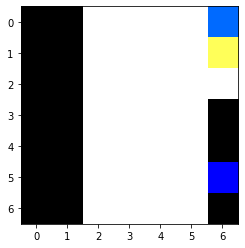

In [96]:
plt.imshow(model.weights[3][:,:,:,0]*255)
plt.show()

In [97]:
# model.load_weights('best/checkpoint/best_model') # only works with tf 2.3... pip --upgrade tensorflow?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


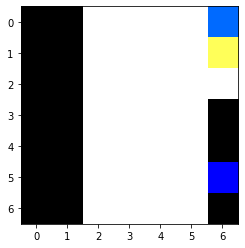

In [99]:
plt.imshow(model.weights[3][:,:,:,0]*255)
plt.show()

In [118]:
test_1 = 'validation/agena/0_224x224_326.947,23.59369,309.7574_64.46893.not_distorted.png'
test_2 = 'validation/agena/101_224x224_71.4465,240.1759,232.6926_66.96285.not_distorted.png'
test_3 = 'validation/agena/115_224x224_296.0463,292.6669,41.97545_97.07749.not_distorted.png'

In [110]:
test_1 = 'validation/ACRIMSAT/106_224x224_34.15004,141.0018,219.459_8.949909.not_distorted.png'
test_2 = 'validation/ACRIMSAT/110_224x224_283.0061,155.0577,52.44717_14.0571.not_distorted.png'
test_3 = 'validation/ACRIMSAT/119_224x224_30.34425,276.6814,289.9302_5.037784.not_distorted.png'

In [106]:
test_1 = 'validation/MGS/118_224x224_325.3529,132.9988,226.0667_209.7786.not_distorted.png'
test_2 ='validation/MGS/127_224x224_11.2287,49.4095,333.5733_194.1013.not_distorted.png'
test_3 ='validation/MGS/129_224x224_61.56558,78.43399,123.2387_134.0126.not_distorted.png'

In [119]:
from PIL import Image

In [122]:
image = Image.open(test_1)
# display(image)
# print(model.predict(np.array(image).reshape(-1,224,224,3)))
# image = Image.open(test_2)
# display(image)
# print(model.predict(np.array(image).reshape(-1,224,224,3)))
# image = Image.open(test_3)
# display(image)
# print(model.predict(np.array(image).reshape(-1,224,224,3)))

model.predict(np.array(image).reshape(-1,224,224,3))

# def ImageDisplay(rawimage):
#     image = Image.open(rawimage)
#     display(image)
#     print(model.predict(np.array(image).reshape(-1,224,224,3)))
# ImageDisplay(test_1)
# ImageDisplay(test_2)
# ImageDisplay(test_3)

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]], dtype=float32)

In [28]:
test_ds_gen = DatasetGenerator('validation', multitask=True, distortion=True, evaluate=True) # replace with test and multitask=True
test_ds_gen.classes

['Odyssey',
 'LRO',
 'NPP',
 'MGS',
 'Juno',
 'MESSENGER',
 'MRO',
 'Dawn',
 'chandra',
 'MMS',
 'cassini',
 'Pioneer',
 'aqua',
 'cloudsat',
 'agena',
 'ACRIMSAT',
 'Rosetta',
 'Deep']

In [29]:
model.predict(np.array(image).reshape(-1,224,224,3))

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]], dtype=float32)

In [30]:
less_test_1 = 'validation/MGS/1_224x224_328.3458,301.9597,112.9494_168.6099_8_0.381_100_32.less_distorted.png'
less_test_2 = 'validation/MGS/10_224x224_71.7444,359.5365,297.9262_193.8118_8_0.381_100_32.less_distorted.png'
less_test_3 = 'validation/MGS/124_224x224_328.3044,327.2347,196.8601_291.8083_8_0.381_100_32.less_distorted.png'

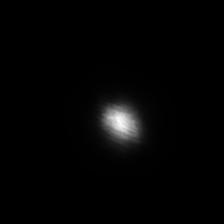

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


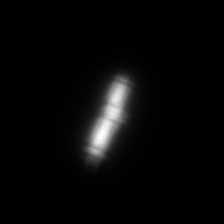

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


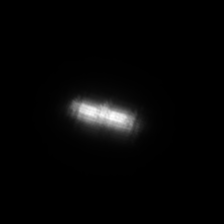

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


In [33]:
image = Image.open(less_test_1)
display(image)
print(model.predict(np.array(image).reshape(-1,224,224,3)))
image = Image.open(less_test_2)
display(image)
print(model.predict(np.array(image).reshape(-1,224,224,3)))
image = Image.open(less_test_3)
display(image)
print(model.predict(np.array(image).reshape(-1,224,224,3)))

feature_maps = model.predict(np.array(image).reshape(-1,224,224,3))

# def ImageDisplay(rawimage):
#     image = Image.open(rawimage)
#     display(image)
#     print(model.predict(np.array(image).reshape(-1,224,224,3)))
# ImageDisplay(less_test_1)
# ImageDisplay(less_test_2)
# ImageDisplay(less_test_3)

IndexError: too many indices for array

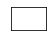

In [51]:
#Filter map visualization 
square = 8
index = 1
for _ in range(square):
	for _ in range(square):
        
		ax = plt.subplot(square, square, index)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(feature_maps[-1,:,:], cmap='viridis')
		index += 1
print(feature_maps)      
plt.show()
for layer in model.layers:
    print(layer.name)

In [64]:
#Filter map visualization
from tensorflow.keras.models import Model
inp= model.inputs 
print(inp)
out1= model.layers[0].output  
print('*' * 40)
print(out1)
feature_map_1= Model(inputs= inp, outputs= out1)  
feature_map_1.summary()
model.summary()

[<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>]
****************************************
Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_____________

## Download Test Dataset and Perform Predictions

In [36]:
images = []
labels = []
predictions = []
test_ds_gen = DatasetGenerator('validation', multitask=True, distortion=True, evaluate=True) # replace with test and multitask=True
batch_iter = iter(test_ds_gen)

In [13]:
# TODO: some progress stats would be nice
for _ in range(32): #range(test_ds_gen.steps):
    batch_images, batch_labels = next(batch_iter)
    images.append(batch_images)
    labels.append(batch_labels)
    batch_pred = model.predict_on_batch(batch_images)
    predictions.append(batch_pred)
    break

/home/ec2-user/SageMaker/kolmogorov/model/validation/Juno/690_224x224_351.0502,124.0327,24.49222_503.2418_8_0.381_100_32.less_distorted.png 4
/home/ec2-user/SageMaker/kolmogorov/model/validation/MRO/127_224x224_354.7689,262.2314,327.6526_394.5044_8_0.381_100_32.less_distorted.png 6
/home/ec2-user/SageMaker/kolmogorov/model/validation/LRO/861_224x224_21.22314,280.517,339.8729_421.6191_8_0.381_100_32.less_distorted.png 1
/home/ec2-user/SageMaker/kolmogorov/model/validation/MESSENGER/187_224x224_345.4615,356.8484,311.6662_386.1381_8_0.381_100_32.less_distorted.png 5
/home/ec2-user/SageMaker/kolmogorov/model/validation/LRO/287_224x224_15.84582,306.0766,23.9022_555.1903_8_0.381_100_32.less_distorted.png 1
/home/ec2-user/SageMaker/kolmogorov/model/validation/agena/508_224x224_298.3733,212.4854,163.0698_103.9872_8_0.381_100_32.more_distorted.png 14
/home/ec2-user/SageMaker/kolmogorov/model/validation/Juno/198_224x224_33.02921,322.6287,179.045_588.7268_8_0.381_100_32.less_distorted.png 4
/home

In [17]:
np.argmax(batch_pred, 0)

array([ 1, 10,  0,  2, 13, 10,  5,  8, 14, 14,  1, 15,  9, 15, 12,  4,  6,
        3])

In [104]:
test_ds_gen.classes

NameError: name 'test_ds_gen' is not defined

In [40]:
np.argmax(batch_pred, 0)[idx]

3

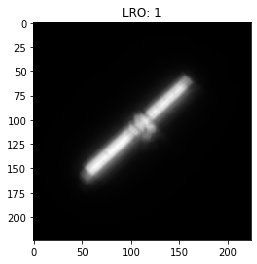

In [48]:
idx = -10
plt.imshow(batch_images[idx])
num = np.argmax(batch_labels[0], 0)[idx]
plt.title(f'{test_ds_gen.classes[num]}: {num}')
plt.show()

In [78]:
#class_labels, distortion_labels = map(list, zip(*labels))
class_labels, orientation_labels, distortion_labels = map(list, zip(*labels))
class_predictions = predictions

## Plot a Confussion Matrix

In [74]:
%matplotlib inline

In [75]:
# TODO: extract only the classification labels and predictions for the confussion matrix
class_predictions = tf.concat(class_predictions, 0)
class_labels = tf.concat(class_labels, 0)

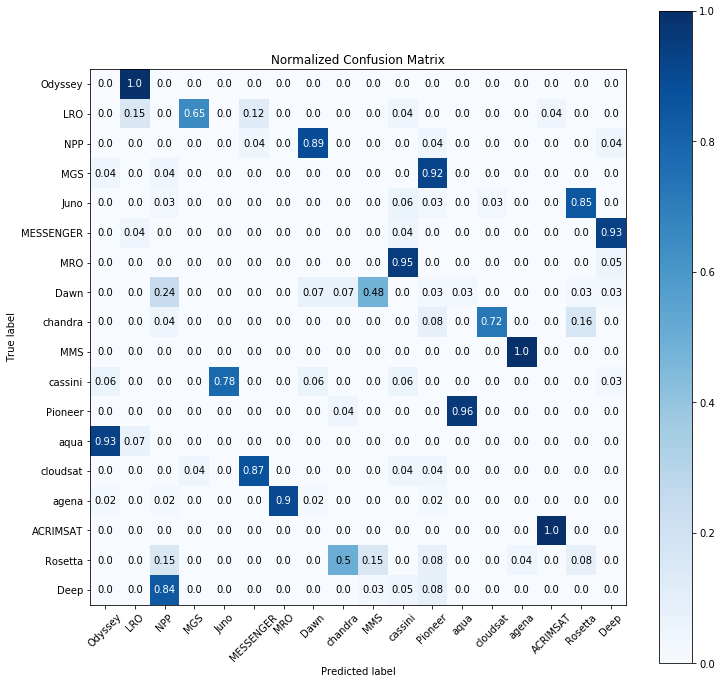

In [76]:
plot_confusion_matrix(
    np.array(test_ds_gen.classes)[np.argmax(class_labels.numpy(), axis=1)], 
    np.array(test_ds_gen.classes)[np.argmax(class_predictions.numpy(), axis=1)], 
    figsize=(12,12),
    labels=test_ds_gen.classes,
    x_tick_rotation=45,
    normalize=True
)
plt.show()

## Orientation Report

In [79]:
# TODO: extract only the classification labels and predictions for the confussion matrix
# orientation_predictions = ...
orientation_labels = tf.concat(orientation_labels,0)
xs, ys, zs = map(list, zip(*orientation_labels))

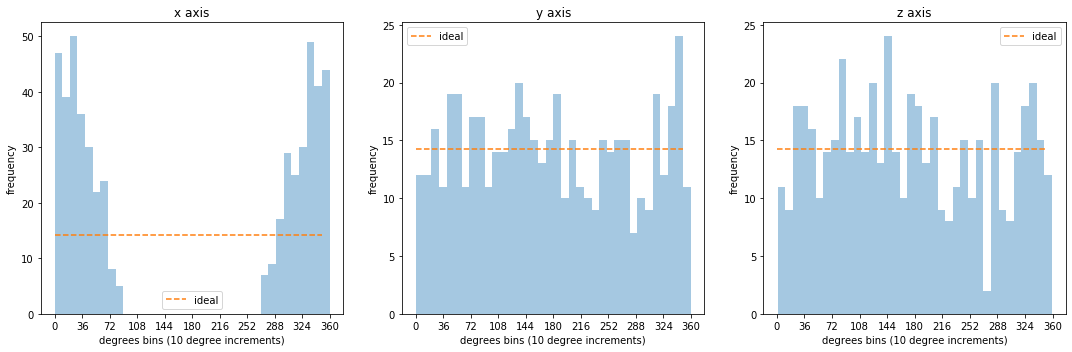

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)
for ax, (k,v) in zip(axes.flatten(), {'x axis':xs, 'y axis':ys, 'z axis':zs}.items()):
    ax.set_title(k)
    sns.distplot(v, bins=36, ax=ax, kde=False)
    ax.set_xlabel('degrees bins (10 degree increments)')
    ax.set_ylabel('frequency')
    ax.set_xticks(np.arange(0,361,36))
    ax.plot(np.arange(0,360,10), [len(v)/36]*36, linestyle='--', label='ideal')
    ax.legend()
fig.tight_layout(w_pad=2.5)
plt.show()

In [83]:
%reset_selective -f "^[x-z]s$"
%reset_selective -f "^orientation_labels$"

## Distortion Report

In [66]:
# TODO: measure how distortion impacted the model
# no clue how to do this with current code...

## Distance Report

In [67]:
# TODO: measure how distortion impacted the model
# no clue how to do this with current code...

### Prediction Demo

In [14]:
def prediction_demo(model, image_batch, label_batch):
    
    predictions = model.predict(image_batch, verbose=1)

    plt.figure(figsize=(10,10))
    
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title('Truth: ' + tf.boolean_mask(classes, label_batch[n])[0].numpy().decode() +
                  '\nPrediction: ' + classes[np.argmax(predictions[n])] +
                  '\nConfidence: ' + str(round(np.max(predictions[n]*100),1)) + '%'
                 )

        plt.axis('off')

    plt.subplots_adjust(top=1.2, right = 1.0)

### Display Demo

In [15]:
demo_image_batch, demo_label_batch, _ = next(iter(val_ds))

16/16 [==============================] - 1s 69ms/sample


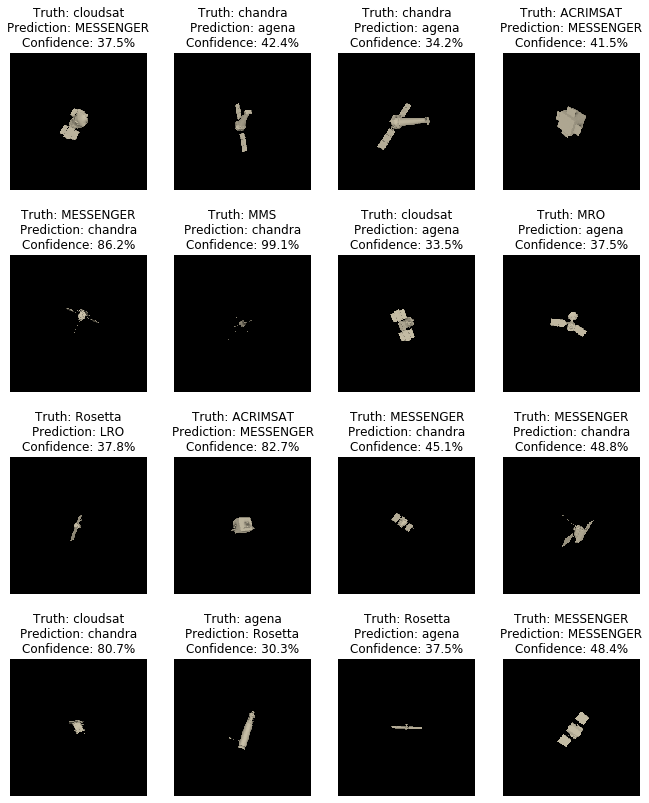

In [17]:
prediction_demo(model, demo_image_batch, demo_label_batch)

In [186]:
def cyclical2degrees(x,y):
    deg = np.degrees(np.arctan(np.divide(x,y)))
    if x == 1 and y == 0:
        return 0
    elif x == 0 and y == 1:
        return 90
    elif x == -1 and y == 0:
        return 180
    elif x == 0 and y == -1:
        return 270
    elif 0 < x <= y:
        # quad 1
        return deg
    elif x < 0 < y:
        # quad 2
         return deg + 180
    elif y <= x < 0:
        # quad 3
        return -1*deg+270
    else:
        #quad 4
        return -1*deg+270

In [188]:
print(cyclical2degrees(1, 0),
      cyclical2degrees(np.sqrt(2)/2, np.sqrt(2)/2),
      cyclical2degrees(1/2, np.sqrt(3)/2),
      cyclical2degrees(0, 1),
      cyclical2degrees(-np.sqrt(2)/2, np.sqrt(2)/2),
      cyclical2degrees(-1/2-np.sqrt(2), np.sqrt(3)/2),
      cyclical2degrees(-1, 0),
      cyclical2degrees(-np.sqrt(2)/2, -np.sqrt(2)/2),
      cyclical2degrees(-np.sqrt(2)/2-np.sqrt(2), -np.sqrt(2)/2+np.sqrt(2)),
      cyclical2degrees(0, -1),
      cyclical2degrees(np.sqrt(2)/2-np.sqrt(2), -np.sqrt(2)/2+np.sqrt(2)),
      cyclical2degrees(np.sqrt(2)/2, -np.sqrt(2)/2))

0 45.0 30.000000000000004 90 135.0 114.3428701752672 180 225.0 108.43494882292201 270 135.0 315.0


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
